In [1]:
import sys, os





# Detect if running inside Jupyter
if "__file__" in globals():
    # Running as a .py script
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
else:
    # Running inside Jupyter Notebook
    # Assume notebook is inside project/reproduction/
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from utils.data_utils_newest import gen_star_from_x1, get_true_frequencies, gen_progressive
from utils.metrics import compute_mse
from utils.spl import random_split_perturb, random_split_estimate
from utils.rs_fd import rs_fd_perturb, rs_fd_estimate
from utils.rs_rfd import rs_rfd_perturb, rs_rfd_estimate
from utils.corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)


mpl.rcParams['pdf.fonttype'] = 42   # TrueType
mpl.rcParams['ps.fonttype'] = 42    # TrueType for EPS


mpl.rc('font', family='DejaVu Serif')


mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['mathtext.fontset'] = 'cm'     # Math font
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30
# ---------------- helpers ----------------
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}



def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # SPL
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # RS+FD
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # RS+RFD (two-phase)
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # Corr-RR
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out






In [44]:
def sweep_vs_phase1(
    n=10000,
    epsilon=0.8,                  # hold epsilon fixed while sweeping Phase I fraction
    R=50,
    corr=0.9,                     # rho for star model: Xj copies X1 with prob corr
    d=4,
    domain=None,
    x1_marginal=None,             # None => uniform on domain
    q_marginal=None,              # None => uniform for non-copy branch
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
    file=None,
):
    """
    Star model data:
      - X1 ~ x1_marginal over `domain`
      - For j >= 2: Xj = X1 w.p. corr; else ~ q_marginal (or uniform if None)
    X-axis: Phase I user fraction (|A|/n). Y-axis: MSE.
    Curves: SPL, RS+FD, RS+RFD, Corr-RR.

    Optimization: SPL and RS+FD are single-phase. For a fixed dataset, their
    MSEs don't depend on the Phase-I fraction. We therefore compute them only
    for the first x-value per run and reuse that value across the remaining x-values.
    """
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(fractions)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = d
    domain_size = len(domain)

    for run in range(R):
        # One dataset per run; reused across all fractions
        df = gen_star_from_x1(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=corr,
            q_marginal=q_marginal,
            seed=None if seed is None else (seed + run + int(1000 * corr)),
        )

        # Cache single-phase results (computed only once at j==0)
        cached_single_phase = {}

        for j, frac in enumerate(fractions):
            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac,     # Corr-RR Phase I fraction
                frac_phase1_rsrfd=frac,    # RS+RFD Phase I fraction
            )

            # --- RS+RFD and Corr-RR: accumulate at every x-value as usual ---
            if "RS+RFD" in keys:
                means["RS+RFD"][j] += res["RS+RFD"]
            if "Corr-RR" in keys and use_corr_rr:
                means["Corr-RR"][j] += res["Corr-RR"]

            # --- SPL & RS+FD: compute once (j==0) per run, then reuse ---
            if "SPL" in keys:
                if j == 0:
                    cached_single_phase["SPL"] = res["SPL"]
                means["SPL"][j] += cached_single_phase["SPL"]
            if "RS+FD" in keys:
                if j == 0:
                    cached_single_phase["RS+FD"] = res["RS+FD"]
                means["RS+FD"][j] += cached_single_phase["RS+FD"]

    # Average over runs
    for k in keys:
        means[k] /= R

    # -------- Plot (keep your exact sizes; only legend layout is custom) --------
    plt.figure(figsize=(10, 8))
    x_vals = [int(100 * f) for f in fractions]

    plt.plot(x_vals, means["SPL"],    '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(x_vals, means["RS+FD"],  '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(x_vals, means["RS+RFD"], '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(x_vals, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel('Users in Phase I (%)', fontsize=40)
    plt.ylabel('MSE', fontsize=40)
    plt.xticks(x_vals, labels=[f"{x}" for x in x_vals])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    # Legend at top center, 2 columns (=> 2 rows for 4 items). Tweak spacing as needed.
    plt.legend(
        fontsize=35,
        loc='upper center',
        ncol=2,
        frameon=True,
        edgecolor='black',
        bbox_to_anchor=(0.50, 1.39),
        labelspacing=0.01,   # vertical space between rows
        columnspacing=1.0,   # horizontal space between columns
        handletextpad=0.8,   # space between marker and text
        handlelength=2       # line symbol length
    )

    # Make room for the legend above without changing fonts
    plt.tight_layout()
    plt.subplots_adjust(top=0.80)

    # Filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSphase1_{attr_count}attr_{domain_size}domain_n_{n}_eps_{_fmt(epsilon)}_rho_{_fmt(corr)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, file + ".pdf"), format="pdf", bbox_inches="tight", pad_inches=0.2)

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"phase1_pct": x_vals})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    # print("Users in Phase I (%) =", x_vals)
    # for k in keys:
    #     print(f"{k} MSE =", means[k])

    return means


In [45]:
# def sweep_vs_phase1(
#     n=10000,
#     epsilon=0.8,
#     R=50,
#     corr=0.9,
#     d=4,
#     domain=None,
#     x1_marginal=None,
#     q_marginal=None,
#     plot_dir=None,
#     csv_dir=None,
#     seed=None,
#     use_corr_rr=True,
#     fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
#     file=None,
# ):
#     """
#     Star model data:
#       - X1 ~ x1_marginal over `domain`
#       - For j >= 2: Xj = X1 w.p. corr; else ~ q_marginal (or uniform if None)
#     X-axis: Phase I user fraction (|A|/n). Y-axis: MSE.
#     Curves: SPL, RS+FD, RS+RFD, Corr-RR.
#     """

#     if domain is None:
#         domain = [0, 1]

#     if x1_marginal is None:
#         x1_marginal = {v: 1.0 / len(domain) for v in domain}

#     keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
#     means = {k: np.zeros(len(fractions)) for k in keys}

#     if seed is not None:
#         np.random.seed(seed)

#     attr_count = d
#     domain_size = len(domain)

#     for run in range(R):
#         df = gen_star_from_x1(
#             n=n,
#             domain=domain,
#             d=d,
#             x1_marginal=x1_marginal,
#             rho=corr,
#             q_marginal=q_marginal,
#             seed=None if seed is None else (seed + run + int(1000 * corr)),
#         )

#         cached_single_phase = {}

#         for j, frac in enumerate(fractions):
#             res = run_all_once(
#                 df,
#                 epsilon,
#                 use_corr_rr=use_corr_rr,
#                 frac_phase1_corr=frac,
#                 frac_phase1_rsrfd=frac,
#             )

#             # RS+RFD and Corr-RR accumulate normally
#             if "RS+RFD" in keys:
#                 means["RS+RFD"][j] += res["RS+RFD"]
#             if "Corr-RR" in keys and use_corr_rr:
#                 means["Corr-RR"][j] += res["Corr-RR"]

#             # SPL and RS+FD only computed once per run
#             if "SPL" in keys:
#                 if j == 0:
#                     cached_single_phase["SPL"] = res["SPL"]
#                 means["SPL"][j] += cached_single_phase["SPL"]

#             if "RS+FD" in keys:
#                 if j == 0:
#                     cached_single_phase["RS+FD"] = res["RS+FD"]
#                 means["RS+FD"][j] += cached_single_phase["RS+FD"]

#     # Average over runs
#     for k in keys:
#         means[k] /= R

#     # ============ Robust Plotting (works in .py + Jupyter) ============
#     plt.figure(figsize=(10, 8))
#     x_vals = [int(100 * f) for f in fractions]

#     plt.plot(x_vals, means["SPL"],    '-o', linewidth=3, markersize=16, label='SPL')
#     plt.plot(x_vals, means["RS+FD"],  '-s', linewidth=3, markersize=16, label='RS+FD')
#     plt.plot(x_vals, means["RS+RFD"], '-^', linewidth=3, markersize=16, label='RS+RFD')

#     if use_corr_rr:
#         plt.plot(x_vals, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

#     plt.xlabel('Users in Phase I (%)', fontsize=40)
#     plt.ylabel('MSE', fontsize=40)
#     plt.xticks(x_vals, labels=[f"{x}" for x in x_vals])
#     plt.tick_params(axis='both', which='major', labelsize=30)
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

#     # Legend inside the figure but high enough for your layout
#     plt.legend(
#         fontsize=35,
#         loc='upper center',
#         ncol=2,
#         frameon=True,
#         edgecolor='black',
#         bbox_to_anchor=(0.5, 1.40),  # SAFE for all backends
#         columnspacing=1.0,
#         handletextpad=0.8,
#         handlelength=2,
#     )

#     # Reserve space at top inside figure so GUI backends don't crop it
#     plt.tight_layout(rect=[0, 0, 1, 0.78])  # leave top 22% empty for legend

#     plt.show()

#     # ================== SAVE PDF (never cropped) ==================
#     if plot_dir:
#         os.makedirs(plot_dir, exist_ok=True)
#         plt.savefig(
#             os.path.join(plot_dir, file + ".pdf"),
#             format="pdf",
#             bbox_inches="tight",
#             pad_inches=0.2,
#         )

#     # ================== CSV output ==================
#     if csv_dir:
#         os.makedirs(csv_dir, exist_ok=True)
#         df_out = pd.DataFrame({"phase1_pct": x_vals})
#         for k in keys:
#             df_out[k] = means[k]
#         df_out.to_csv(os.path.join(csv_dir, file + ".csv"), index=False)

#     return means


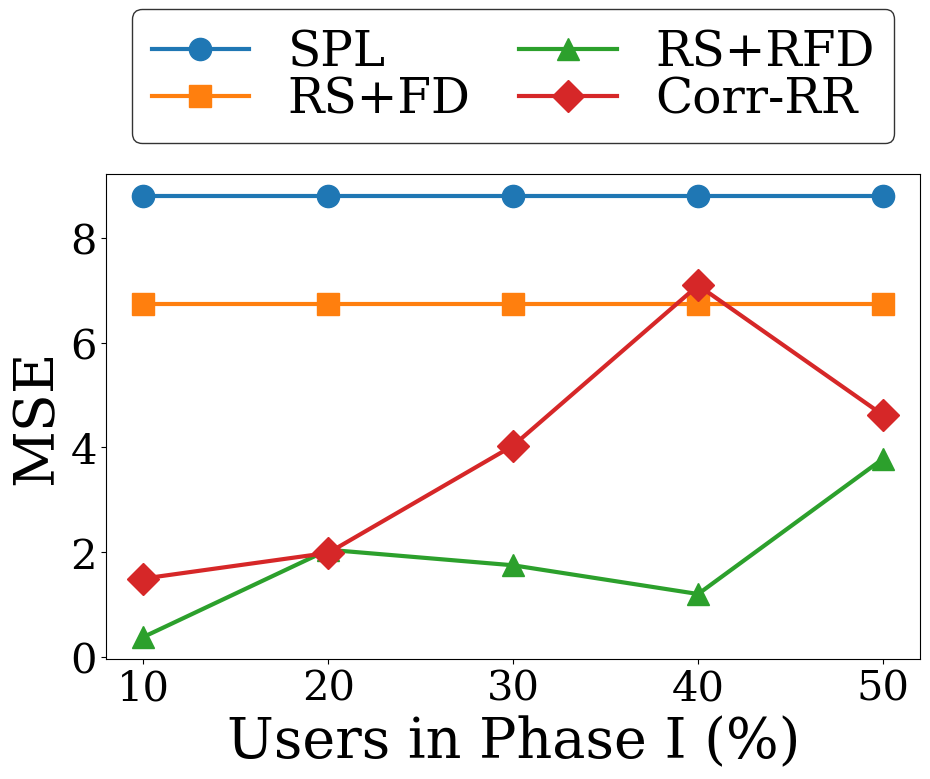

In [47]:
means = sweep_vs_phase1(
    n=200,
    epsilon=0.1,            # pick the ε you want to hold fixed
    R=1,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch

    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
    plot_dir=r"C:\\Users\\ss6365\\Desktop\\Corr-RR\\fig",
    file="fig_9a",
)


In [48]:
def sweep_all_progressive(
    n=10000,
    epsilon=0.8,                  # hold epsilon fixed while sweeping Phase I fraction
    R=50,
    corr=0.9,                     # rho for star model: Xj copies X1 with prob corr
    d=4,
    domain=None,
    x1_marginal=None,             # None => uniform on domain
    q_marginal=None,              # None => uniform for non-copy branch
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
    file=None,
):
    """
    Star model data:
      - X1 ~ x1_marginal over `domain`
      - For j >= 2: Xj = X1 w.p. corr; else ~ q_marginal (or uniform if None)
    X-axis: Phase I user fraction (|A|/n). Y-axis: MSE.
    Curves: SPL, RS+FD, RS+RFD, Corr-RR.

    Optimization: SPL and RS+FD are single-phase. For a fixed dataset, their
    MSEs don't depend on the Phase-I fraction. We therefore compute them only
    for the first x-value per run and reuse that value across the remaining x-values.
    """
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(fractions)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = d
    domain_size = len(domain)

    for run in range(R):
        # One dataset per run; reused across all fractions
        # df = gen_star_from_x1(
        #     n=n,
        #     domain=domain,
        #     d=d,
        #     x1_marginal=x1_marginal,
        #     rho=corr,
        #     q_marginal=q_marginal,
        #     seed=None if seed is None else (seed + run + int(1000 * corr)),
        # )


        df = gen_progressive(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=corr,
            q_marginal=q_marginal,
            seed=seed
        )


        # Cache single-phase results (computed only once at j==0)
        cached_single_phase = {}

        for j, frac in enumerate(fractions):
            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac,     # Corr-RR Phase I fraction
                frac_phase1_rsrfd=frac,    # RS+RFD Phase I fraction
            )

            # --- RS+RFD and Corr-RR: accumulate at every x-value as usual ---
            if "RS+RFD" in keys:
                means["RS+RFD"][j] += res["RS+RFD"]
            if "Corr-RR" in keys and use_corr_rr:
                means["Corr-RR"][j] += res["Corr-RR"]

            # --- SPL & RS+FD: compute once (j==0) per run, then reuse ---
            if "SPL" in keys:
                if j == 0:
                    cached_single_phase["SPL"] = res["SPL"]
                means["SPL"][j] += cached_single_phase["SPL"]
            if "RS+FD" in keys:
                if j == 0:
                    cached_single_phase["RS+FD"] = res["RS+FD"]
                means["RS+FD"][j] += cached_single_phase["RS+FD"]

    # Average over runs
    for k in keys:
        means[k] /= R

    # -------- Plot (keep your exact sizes; only legend layout is custom) --------
    plt.figure(figsize=(10, 8))
    x_vals = [int(100 * f) for f in fractions]

    plt.plot(x_vals, means["SPL"],    '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(x_vals, means["RS+FD"],  '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(x_vals, means["RS+RFD"], '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(x_vals, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel('Users in Phase I (%)', fontsize=40)
    plt.ylabel('MSE', fontsize=40)
    plt.xticks(x_vals, labels=[f"{x}" for x in x_vals])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    # Legend at top center, 2 columns (=> 2 rows for 4 items). Tweak spacing as needed.
    plt.legend(
        fontsize=35,
        loc='upper center',
        ncol=2,
        frameon=True,
        edgecolor='black',
        bbox_to_anchor=(0.50, 1.39),
        labelspacing=0.01,   # vertical space between rows
        columnspacing=1.0,   # horizontal space between columns
        handletextpad=0.8,   # space between marker and text
        handlelength=2       # line symbol length
    )

    # Make room for the legend above without changing fonts
    plt.tight_layout()
    plt.subplots_adjust(top=0.80)

    # Filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSphase1_{attr_count}attr_{domain_size}domain_n_{n}_eps_{_fmt(epsilon)}_rho_{_fmt(corr)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, file + ".pdf"), format="pdf", bbox_inches="tight", pad_inches=0.2)

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"phase1_pct": x_vals})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, file + ".csv"), index=False)

    # print("Users in Phase I (%) =", x_vals)
    # for k in keys:
    #     print(f"{k} MSE =", means[k])

    return means


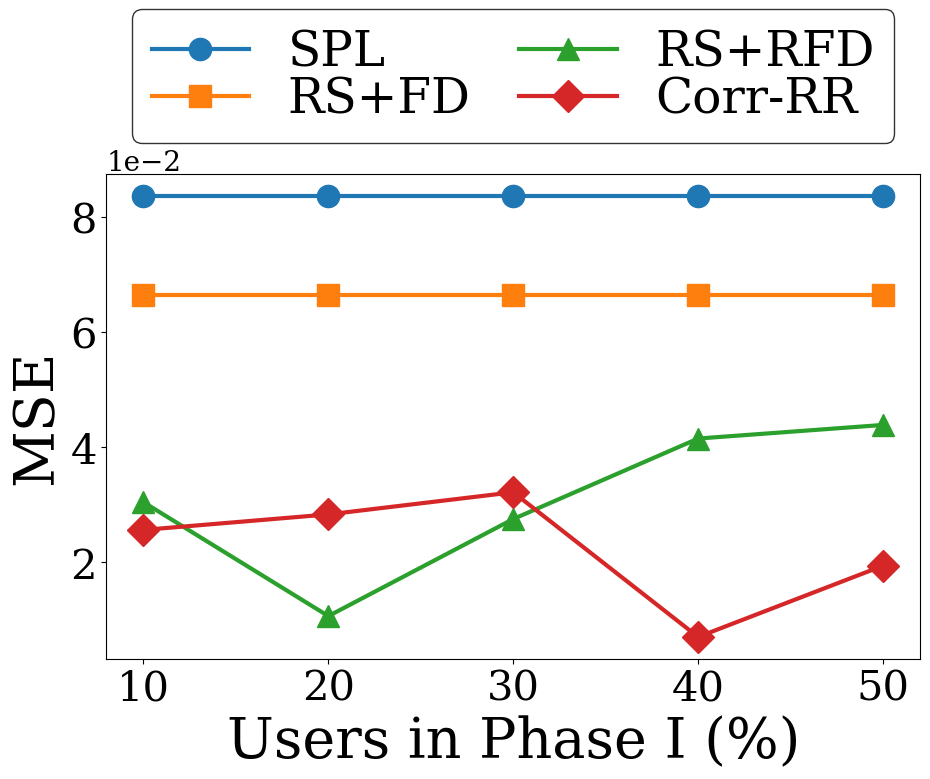

In [49]:

means = sweep_all_progressive(
    n=200,
    epsilon=1,            # pick the ε you want to hold fixed
    R=1,
    corr=0.1,
    d=2,
    domain=[0,1,2,3],
    x1_marginal={0:0.4, 1:0.3, 2:0.2, 3:0.1},  # or None for uniform
    q_marginal=None,        # None => uniform in the non-copy branch
    #plot_dir="plots",
    #csv_dir="csvs",
    seed=42,
    use_corr_rr=True,
    fractions=(0.10, 0.20, 0.30, 0.40, 0.50),
    plot_dir=r"C:\\Users\\ss6365\\Desktop\\Corr-RR\\fig",
    file="fig_10a",
)
